In [1]:
# 2nd chapter from Metrics Manifesto by R. Seiersen, "translated" to Python, part 2
!wget https://raw.githubusercontent.com/ribsy/mdata/main/tmm_start.csv

--2023-03-29 14:18:56--  https://raw.githubusercontent.com/ribsy/mdata/main/tmm_start.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2738755 (2.6M) [text/plain]
Saving to: ‘tmm_start.csv’

tmm_start.csv       100%[===================>]   2.61M  13.0MB/s    in 0.2s    

2023-03-29 14:18:57 (13.0 MB/s) - ‘tmm_start.csv’ saved [2738755/2738755]



In [6]:
# create the dataset from csv file and correct the column names: first.seen and last.seen replacing dot with underscore
import pandas as pd
df = pd.read_csv('tmm_start.csv')
df.rename(columns = {'first.seen':'first_seen', 'last.seen':'last_seen', 'week.fseen':'week_fseen','week.lseen':'week_lseen'}, inplace = True)

In [7]:
df.head()

,idTeam,team,nDays,id,dev_maturity,audit,exposure,exposure_id,severity,hits,...,time_adj,beta_prob,fix_time,fix_date,status,first_seen,last_seen,week_fseen,week_lseen,group
0,2,partner audit,3,1,3,0,partner,2,extreme,1,...,0.066189,0.349598,19,22,0,2020-01-04,2020-01-23,1,4,1
1,2,partner audit,17,2,3,0,partner,2,extreme,1,...,0.010000,0.076161,1,18,0,2020-01-18,2020-01-19,3,3,1
2,2,partner audit,199,3,3,0,partner,2,extreme,1,...,0.097270,0.000689,1,200,0,2020-07-18,2020-07-19,29,29,1
3,3,internal audit,88,4,3,0,internal,3,extreme,1,...,0.334085,0.342206,31,119,0,2020-03-29,2020-04-29,13,18,1
4,3,internal audit,113,5,3,0,internal,3,extreme,2,...,0.010000,0.308934,14,127,0,2020-04-23,2020-05-07,17,19,1


In [8]:
# We need two additional columns with delta - the duration of a vulnerability until it's fixed/gone and status - whether it's get censored.

from datetime import datetime as dt
from datetime import timedelta

# Iterate over two columns in dataframe, using `zip`, convert the string to datetime and get the delta+1 day
delta = [(dt.strptime(stop,"%Y-%m-%d") - dt.strptime(start,"%Y-%m-%d"))+timedelta(days=1) for start, stop in zip(df['first_seen'],df['last_seen'])]
# convert dtype64 from nanoseconds to days, otherwise the plot's x axis gets weird numbers
df['delta'] = [x.days for x in delta]
# Iterate over last.seen column and check whether it gets censored 
df['status'] = [1 if (dt.strptime(stop,"%Y-%m-%d") < dt.strptime('2020-12-31',"%Y-%m-%d")) else 0 for stop in df['last_seen']]

In [39]:
# filter out by start date <= 2020-10-01, idTeam == 1 and group == 1
df_flt = df[(df.idTeam == 1) & (df.group == 1) & (pd.to_datetime(df.first_seen) <= pd.to_datetime('2020-10-01'))]

In [46]:
df_flt.head()

,idTeam,team,nDays,id,dev_maturity,audit,exposure,exposure_id,severity,hits,...,beta_prob,fix_time,fix_date,status,first_seen,last_seen,week_fseen,week_lseen,group,delta
33,1,external audit,4,34,3,0,external,1,critical,1,...,0.227832,24,28,1,2020-01-05,2020-01-29,1,5,1,25
34,1,external audit,26,35,3,0,external,1,critical,3,...,0.337955,24,50,1,2020-01-27,2020-02-20,4,8,1,25
35,1,external audit,26,36,3,0,external,1,critical,3,...,0.301927,27,53,1,2020-01-27,2020-02-23,4,8,1,28
36,1,external audit,26,37,3,0,external,1,critical,3,...,0.350622,29,55,1,2020-01-27,2020-02-25,4,9,1,30
37,1,external audit,28,38,3,0,external,1,critical,1,...,0.217580,21,49,1,2020-01-29,2020-02-19,5,8,1,22


In [68]:
# Survival function KMF - plot it simple with confidence interval
import datetime
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

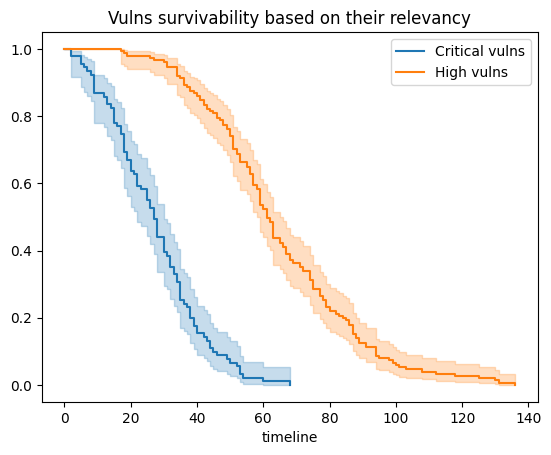

In [69]:
# Define critical and high strata and plot them with confidence intervals
critical =  ((df_flt.severity == 'extreme') | (df_flt.severity == 'critical'))
high = (df_flt.severity == 'high')
ax = plt.subplot()
kmf = KaplanMeierFitter()
kmf.fit(durations=df_flt[critical].delta, event_observed=df_flt[critical].status, label='Critical vulns')
kmf.plot_survival_function(ax=ax)
kmf.fit(durations=df_flt[high].delta, event_observed=df_flt[high].status, label='High vulns')
kmf.plot_survival_function(ax=ax)
plt.title('Vulns survivability based on their relevancy')
plt.show()

In [70]:
# filter out by start date <= 2020-10-01 and group == 1
df_flt = df[(df.group == 1) & (pd.to_datetime(df.first_seen) <= pd.to_datetime('2020-10-01'))]

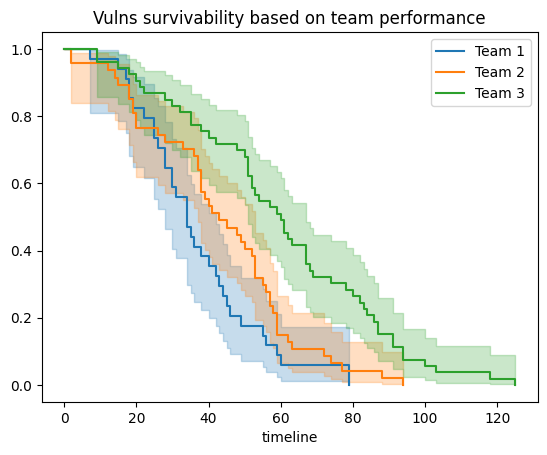

In [71]:
# Define teams strata and plot them with confidence intervals - teams performance
team1 = (df_flt.idTeam == 1)
team2 = (df_flt.idTeam == 2)
team3 = (df_flt.idTeam == 3)
ax = plt.subplot()
kmf = KaplanMeierFitter()
kmf.fit(durations=df_flt[team1].delta, event_observed=df_flt[team1].status, label='Team 1')
kmf.plot_survival_function(ax=ax)
kmf.fit(durations=df_flt[team2].delta, event_observed=df_flt[team2].status, label='Team 2')
kmf.plot_survival_function(ax=ax)
kmf.fit(durations=df_flt[team3].delta, event_observed=df_flt[team3].status, label='Team 3')
kmf.plot_survival_function(ax=ax)
plt.title('Vulns survivability based on team performance')
plt.show()